# Generate some output in R

The idea is to call this script from the python notebook for each image separately as part of the pipeline. It will create one .csv per image and some basic quality control visualisations. 

In [65]:
pxl_per_um <- 1030/(20*400) # Measured manually
# pxl_per_um
um_per_pxl <- 1/pxl_per_um
um_per_pxl

[1] 7.76699

## Define image to be processed

In [66]:
results_folder <- 'stella/output/images/STELLA_sA400_semiauto_Merge_500-20_B04_D7'

In [67]:
image_name <- basename(results_folder)
image_name

[1] "STELLA_sA800_semiauto_Merge_50-20_A06_D7"

## Dependencies

In [68]:
require("tidyr")
require("dplyr")
require("stringr")
require("ggplot2")
require("ggpubr")
require("sp") # to define spatial polygons in R
require("psych") # creates very easy summary data using the describe() function
# require("raster") # To save a shapefile 
getwd()

[1] "/home/host_home/figures/automated_image_analysis/semi_automated"

## Data

### Spheroids

In [69]:
spheroids_file <- paste0(results_folder,"/cellprofiler/cp_output_spheroids_filtered.csv")
spheroids <- read.csv(spheroids_file)
# spheroids <- read.csv('stella/input/STELLA_sA400_fullyauto_Merge_50-20_C04_D7/cellprofiler/cp_output_spheroids_filtered.csv')

In [70]:
df <- spheroids 
metadata <- cbind(df[,c(1,2,3,6)], as.data.frame(str_split_fixed(df$FileName_original, "_", 7))) %>%
    setNames(., c("ID","image_id","type","FileName_original","Experiment", "Platform", "Handling", "Merge", "asp_disp", "Well", "Day")) %>%
    select(-Merge, -type)%>%
    separate(col = asp_disp, into = c("Aspiration", "Dispension"), sep = "-", remove = TRUE) %>%
    mutate_all(~gsub(".tif", "", .)) %>%
    mutate(across(where(is.character), as.factor))%>%
    mutate(ID = 1:length(df[,1]))%>%
    mutate(ID = as.numeric(ID))
# glimpse(metadata)

In [71]:
names(df)[2] <- 'ID'
df <- full_join(metadata,df, by = "ID")
# glimpse(df)
# View(df)

### Grid

In [72]:
grid_file <- paste0(results_folder,"/",image_name,"_grid.csv")
grid <- read.csv(grid_file)

## Define polygon object

Determine a set of coordinates for the vertices. Note that the first and last vertex need to be the same to 'close' the polygon.

https://mhallwor.github.io/_pages/basics_SpatialPolygons

In [73]:
polist <- list()

for (i in 1:length(grid[,1])) {
    name <- as.character(i)
    square <- as.numeric(grid[i,])
    x_coords <- square[c(5,7,9,11,5)]
    y_coords <- square[c(6,8,10,12,6)]
    poly <- Polygon(cbind(x_coords,y_coords)) # one polygon is created 
    polyclass <- Polygons(list(poly), ID = name) # Give object class 'polygon'
    polist <- c(polist,polyclass)
}

# Turn the individual polygons in a list of spatial polygons
all_polygons <- SpatialPolygons(polist)

In [74]:
locations <- df %>% select(AreaShape_Center_X,AreaShape_Center_Y) %>% SpatialPoints
# glimpse(locations)

### Save the polygons as a shapefile

In [75]:
# require(raster)
# shapefile(x = all_polygons, file = "'stella/output/images/STELLA_sA400_fullyauto_Merge_50-20_C04_D7/polygons_shapefile.shp")

## Overlay points and polygons

there are 2 ways: via fs package or via sp package. The sf seems easier but i cannot get it installed... https://r-spatial.github.io/sf/

So we use the 'sp' package again
https://mhallwor.github.io/_pages/basics_SpatialPolygons
https://gis.stackexchange.com/questions/63793/how-to-overlay-a-polygon-over-spatialpointsdataframe-and-preserving-the-spdf-dat

In [76]:
# Create vector with the polygon each spheroid is a part of. 
overlap <- over(locations , all_polygons , fn = NULL)
# make this into a dataframe
df_overlap <- data.frame("spheroid" = 1:length(locations), "microwell" = overlap)
df_overlap$colored_spheroids <- ifelse(is.na(df_overlap$microwell), 'red', 'green')
# Add a column to spheroids df to specify in which detectable well it is located
df$uwell <- df_overlap$microwell
# glimpse(df_overlap)

### Plot all microwells

In [77]:
polys_df <- data.frame('nr' = c(1:length(all_polygons)))
non_empty_uwells <- df_overlap %>% select(microwell) %>% drop_na()

polys_df$with_spheroid <- 0
polys_df$with_spheroid[unlist(non_empty_uwells)] <- 1
polys_df$color <- ifelse(polys_df$with_spheroid == 1, 'green', 'red')
# glimpse(polys_df)

In [78]:
output_png <- paste0("stella/output/images/",image_name,"/",image_name,"_grid.png")

png(file=output_png,width=1600, height=1200)
plot(all_polygons, col = polys_df$color)
points(locations, pch = 20, cex = 1)
dev.off()

png 
  2

In [79]:
output_png <- paste0("stella/output/images/",image_name,"/",image_name,"_only_grid.png")

png(file=output_png,width=1600, height=1200)
plot(all_polygons)
dev.off()

png 
  2

### Calculate percentage of microwells containing a spheroid

In [80]:
percentage <- 100*sum(polys_df$with_spheroid)/length(polys_df$nr)
defects <- 100 - percentage
print(paste("From a total of ", length(polys_df$nr), "microwells, ", percentage, "% contains a spheroid, and ", defects, "% are empty."))

[1] "From a total of  170 microwells,  94.1176470588235 % contains a spheroid, and  5.88235294117646 % are empty."


## Make some basic overview plots

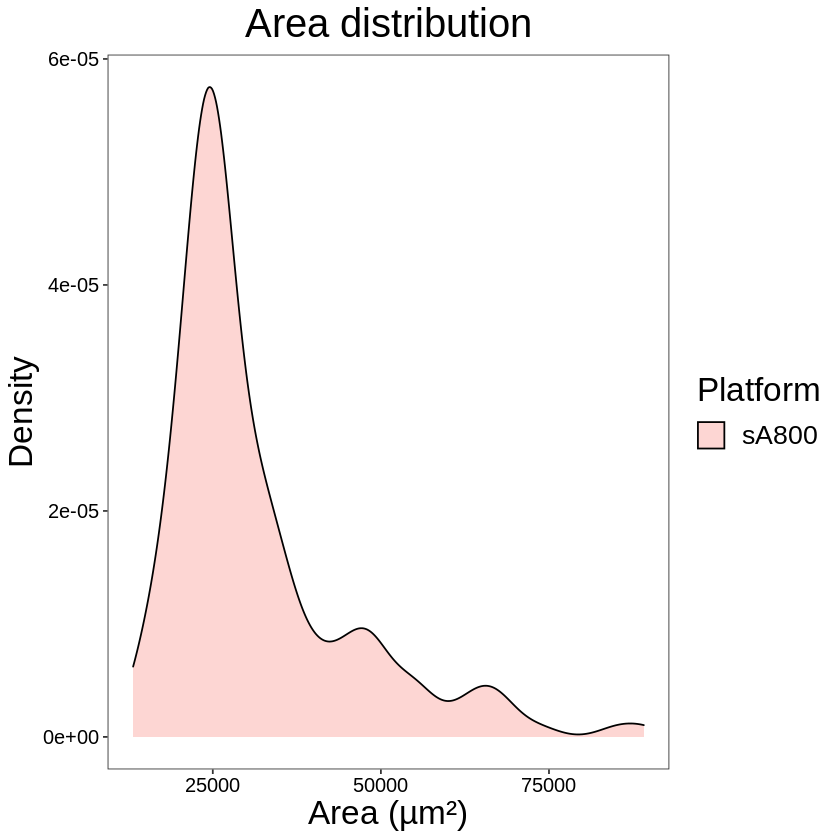

In [81]:
# Area density
df <- df %>% mutate(AreaShape_Area = AreaShape_Area*um_per_pxl*um_per_pxl)
p <- ggplot(df, aes(AreaShape_Area, fill = Platform, group = Platform)) + 
        geom_density(alpha = 0.3)+
        # geom_vline(data=mu, aes(xintercept=grp.mean, color=Platform),linetype="dashed")+
        labs(x = "Area (µm²)", y = "Density", title = "Area distribution")+
        theme_bw()+
        theme(plot.title = element_text(hjust = 0.5), 
        text = element_text(size = 20),
        strip.text = element_text(size = 12), 
        axis.text = element_text(size = 12, color = "black"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank())
p

output_png <- paste0("stella/output/images/",image_name,"/",image_name,"_Density_Area.png")
ggsave(filename = output_png, plot = p, dpi = 300, width = 8, height = 8) 

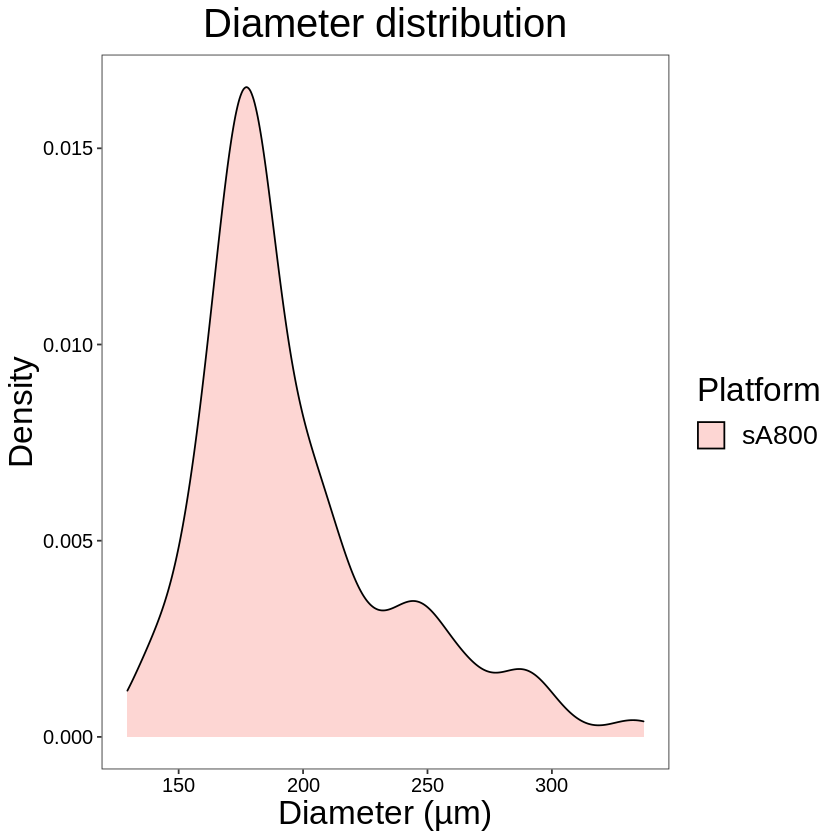

In [82]:
# Diameter density
df <- df %>% mutate(AreaShape_EquivalentDiameter = AreaShape_EquivalentDiameter*um_per_pxl)
p <- ggplot(df, aes(AreaShape_EquivalentDiameter, fill = Platform, group = Platform)) + 
        geom_density(alpha = 0.3)+
        # geom_vline(data=mu, aes(xintercept=grp.mean, color=Platform),linetype="dashed")+
        labs(x = "Diameter (µm)", y = "Density", title = "Diameter distribution")+
        theme_bw()+
        theme(plot.title = element_text(hjust = 0.5), 
        text = element_text(size = 20),
        strip.text = element_text(size = 12), 
        axis.text = element_text(size = 12, color = "black"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank())
p

output_png <- paste0("stella/output/images/",image_name,"/",image_name,"_Density_Diameter.png")
ggsave(filename = output_png, plot = p, dpi = 300, width = 8, height = 8) 

# Projected volume

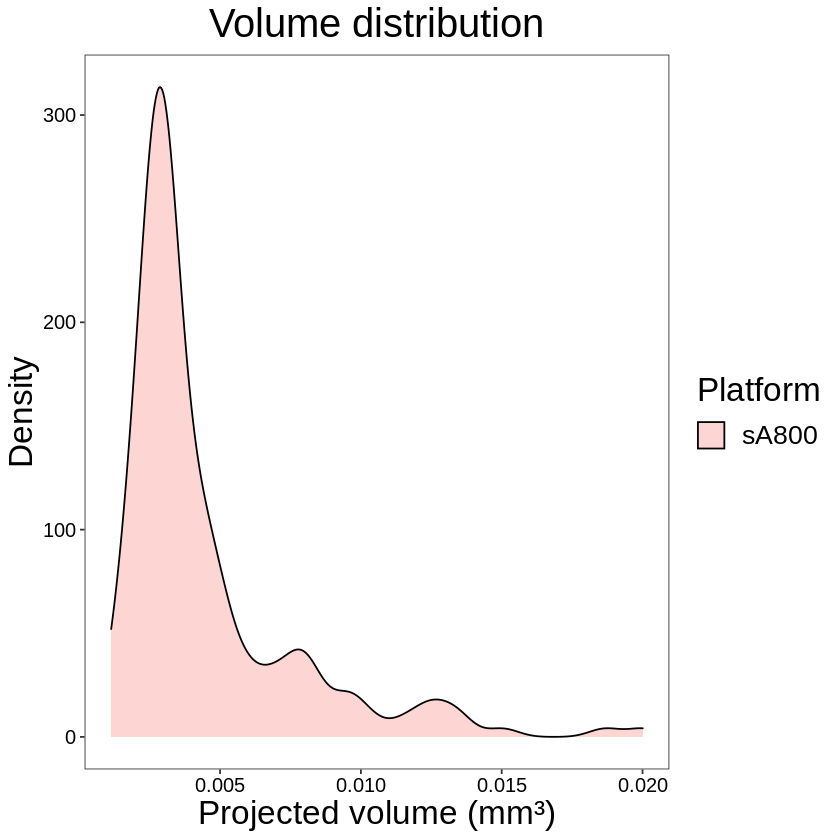

In [83]:
df <- df %>% mutate("Projected_volume_mm3" = 10^-9*(4/3*pi*(AreaShape_EquivalentDiameter/2)^3))

p <- ggplot(df, aes(Projected_volume_mm3, fill = Platform, group = Platform)) + 
        geom_density(alpha = 0.3)+
        # geom_vline(data=mu, aes(xintercept=grp.mean, color=Platform),linetype="dashed")+
        labs(x = "Projected volume (mm³)", y = "Density", title = "Volume distribution")+
        theme_bw()+
        theme(plot.title = element_text(hjust = 0.5), 
        text = element_text(size = 20),
        strip.text = element_text(size = 12), 
        axis.text = element_text(size = 12, color = "black"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank())
p

output_png <- paste0("stella/output/images/",image_name,"/",image_name,"_Density_Volume.png")
ggsave(filename = output_png, plot = p, dpi = 300, width = 8, height = 8) 

# Spheroid locations and diameter

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



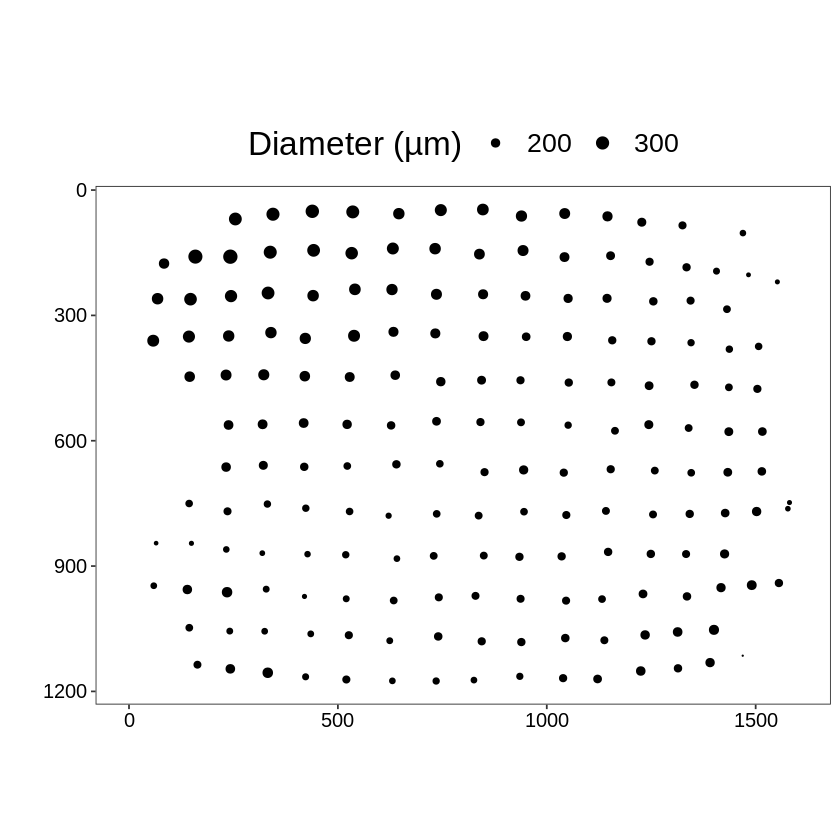

In [98]:
# Make sure the pointsize range stays the same for all images 
maxrange <- max(df$AreaShape_EquivalentDiameter)/100

p <- ggplot(df, aes(x=AreaShape_Center_X, y=AreaShape_Center_Y))+
    geom_point(aes(size = AreaShape_EquivalentDiameter))+
    scale_size(range=c(0,maxrange),breaks=c(0,100,200,300,400,500),labels=c("","100","200","300","400","500"))+
    labs(x = "", y = "", title = "", size = "Diameter (µm)")+
    coord_fixed()+
    xlim(0,1600)+
    ylim(0,1200)+
    scale_y_reverse()+
    theme_bw()+
        theme(plot.title = element_text(hjust = 0.5), 
        text = element_text(size = 20),
        strip.text = element_text(size = 12), 
        axis.text = element_text(size = 12, color = "black"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position="top")
p

output_png <- paste0("stella/output/images/",image_name,"/",image_name,"_Location_Diameter.png")
ggsave(filename = output_png, plot = p, dpi = 300, width = 8, height = 6) 

# Save dataset

## Save the full dataset

In [ ]:
# Add grid detection results to df
df <- df %>% mutate("microwells" = length(polys_df$nr),
                    "spheroids" = length(df$Number_Object_Number),
                    "inwell_perc" = percentage,
                    "outwell_perc" = defects)

output_csv <- paste0("stella/output/images/",image_name,"/",image_name,"_output_data.csv")
write.csv(df,output_csv)
glimpse(df)

## Save a summary dataset

In [ ]:
# Create summary table
df_summary <- as.data.frame(t(describe(df[,16:length(df)])))
df_summary <- cbind(df[1:13,1:11], df_summary)
# Add metadata
metadata_cols <- c(1:11)
df_summary$Row <- substr(df_summary$Well, 1,1)
df_summary$Column <- substr(gsub("0","",df_summary$Well),2,3)
glimpse(df_summary)

In [ ]:
# Save summary data
summary_csv <- paste0("stella/output/images/",image_name,"/",image_name,"_summary_data.csv")
write.csv(df_summary,summary_csv)